# Clustering light curves
## How do you reliably isolate transients that occur at random times and durations in a light curve?
I've been stuck on this problem for years, running around in circles, but this method works $really$ well at isolating all transients from the nominal light curve. It works on the principle of clustering like points though the scikit-learn OPTICS clustering algorithm, where points that meet some pre-determined clustering clustering conditions will be clustered into groups. 

Just applying clustering to a light curve doesn’t work well. The reason for this is that the background light curves are often broken apart by transients, so one ends up with multiple instances of backgrounds arising in the clusters, then the next question becomes how do you reliably join background clusters? There are solutions, but clustering on a light curve in time and flux space, is a poorly defined task.

Instead, we can look at another combination of key properties. The main distinguishing factors between background and transients, is that the background has low flux and small gradients from point to point. A transient can then be characterised by segments of rapidly changing flux (large gradients), and elevated flux, therefore, you should expect transients to form a distinct and separate group from the background in gradient and flux space. As we will show this is indeed the case, and a density clustering algorithm, such as the $\texttt{scikit-learn}$ OPTICS clustering algorithm can reliably and quickly separate background from transients in a single cluster.

Building on this method, we can perform more reliable fits and subtractions for stellar variability, and isolate all significant transient events present in a light curve.

In [1]:
# initialise packages
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import tessreduce as tr
import numpy as np
import pandas as pd 
import lightkurve as lk
from astropy.coordinates import SkyCoord
from astropy import units as u
from sklearn.cluster import OPTICS

## SVS 1755: Good example for clustering 

In [ ]:
tpf = tr.Get_TESS()
res = tr.Quick_reduce(tpf,calibrate=False)
flux = res['flux']
med_frame = tr.Get_ref(flux)
tab = Unified_catalog(tpf,magnitude_limit=18)

col = tab.col.values + .5
row = tab.row.values + .5
pos = np.array([col,row]).T

index, med_cut, stamps = tr.Isolated_stars(pos,tab['tmag'].values,flux,med_frame,Distance=5,Aperture=3)


In [10]:
c = SkyCoord('10 18 13.12 +71 55 44.2', unit=(u.hourangle, u.deg), frame='icrs')
tess = lk.search_tesscut(c,sector=21)
# download the image cutout with size 50
tpf = tess.download(cutout_size=50)
# use the tessreduce quick reduce function to get a light curve of the central pixel with a 3x3 aperture
res = tr.Quick_reduce(tpf,calibrate=False)
# we only really care about the lightcurve here
lc = res['lc']

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


<IPython.core.display.Javascript object>


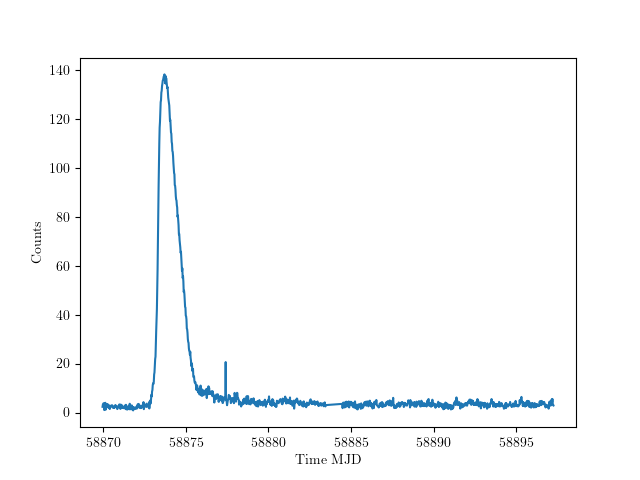

In [11]:
# what does the light curve look like?
tr.Plotter(lc[0],lc[1])

## Custer the data

<IPython.core.display.Javascript object>


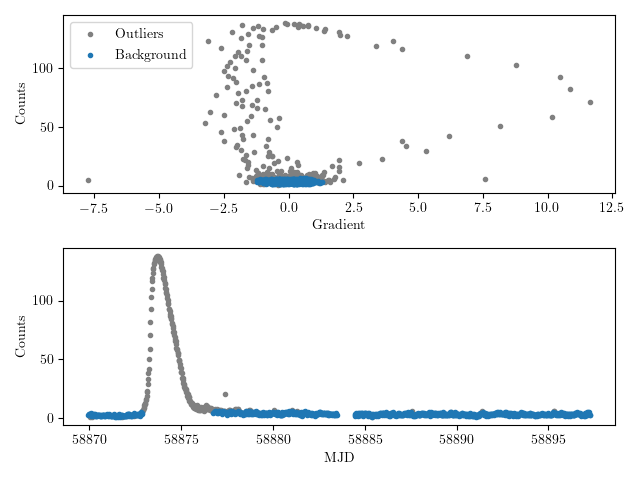

In [12]:
# clustering the light curve is as simple as the following lines 
arr = np.array([np.gradient(lc[1]),lc[1]])
clust = OPTICS(min_samples=6, xi=.05, min_cluster_size=.05)
opt = clust.fit(arr.T)
lab = opt.labels_
keys = np.unique(opt.labels_)

# lets see how well the clustering did 
colours = ['grey','C0']
labels = ['Outliers','Background']
plt.figure()
plt.subplot(211)
for i in range(len(keys)):
    plt.plot(np.gradient(lc[1])[lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i],label=labels[i])
plt.ylabel('Counts')
plt.xlabel('Gradient')
plt.legend()  

plt.subplot(212)
for i in range(len(keys)):
    plt.plot(lc[0,lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i])
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.tight_layout()

Clearly the clustering has done a fantastic job at isolating the background from the "outliers" caused the nova outburst. As expected, we see in gradient-counts space the background defined by both low counts and low gradients, which can be easily clustered. Similarly, we also see the expected behaviour of the transient, with large positive gradients during the rise and smaller negative gradients during the fall, since the transient rises faster than it falls.

## Event isolation
With this clustering algorithm, we can also easily isolate all transients in a light curve using the Event_isolation function in $\texttt{TESSreduce}$. Event_isolation can be tuned with both the significance of the event above the background, and the duration of the event. The defaults for there parameters are $5\sigma$ significance and a minimum duration of 10 frames, or 5 hours. For stellar flares, it may be nescissary to reduce the duration to capture all flares.

<IPython.core.display.Javascript object>


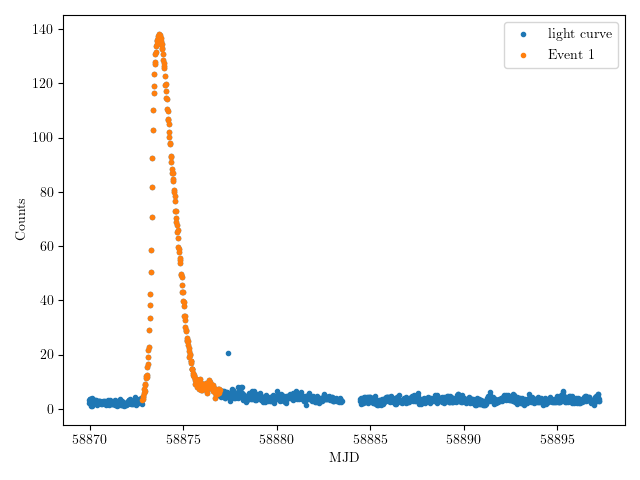

In [13]:
events = tr.Event_isolation(lc,)

# look at the events
plt.figure()
plt.plot(lc[0],lc[1],'.',label='light curve')
for i in range(len(events)):
    plt.plot(lc[0],events[i],'.',label='Event {}'.format(i+1))
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.legend()
plt.tight_layout()

# Detrending
For some sources trends in the light curve, induced by stellar variability, or instrumental artifacts can obscure transients. To Reveal these transients can use clustering to identify the times where there is a transient, exclude those times, then smooth the remaining data to get a representation of stellar variability.

<IPython.core.display.Javascript object>


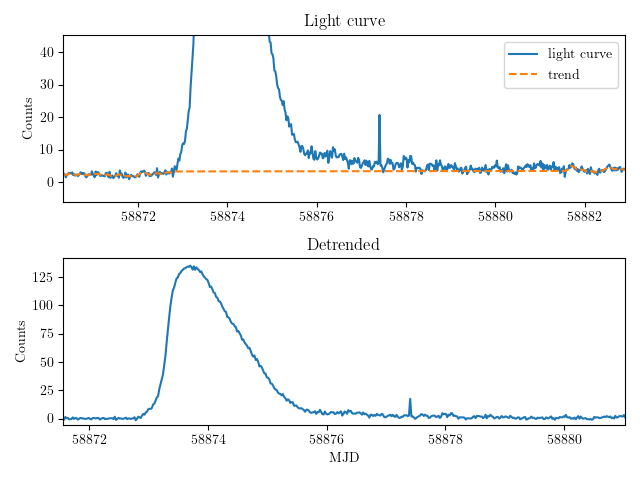

In [14]:
trend = tr.Remove_stellar_variability(lc)

plt.figure()
plt.subplot(211)
plt.title('Light curve')
plt.plot(lc[0],lc[1],label='light curve')
plt.plot(lc[0],trend,'--',label='trend')
plt.legend()
plt.ylabel('Counts')
plt.subplot(212)
plt.title('Detrended')
plt.plot(lc[0],lc[1]-trend)
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.tight_layout()

To convince ourselves that this works, lets look at a worse case.

## OQ Car: Worse case

In [15]:
c = SkyCoord('09 55 58.46 -68 09 41.3', unit=(u.hourangle, u.deg), frame='icrs')
tess = lk.search_tesscut(c,sector=10)
# download the image cutout with size 50
tpf = tess.download(cutout_size=50)
# use the tessreduce quick reduce function to get a light curve of the central pixel with a 3x3 aperture
res = tr.Quick_reduce(tpf,calibrate=False)#,aper=aper_b18)
# we only really care about the lightcurve here
lc = res['lc']

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


<IPython.core.display.Javascript object>


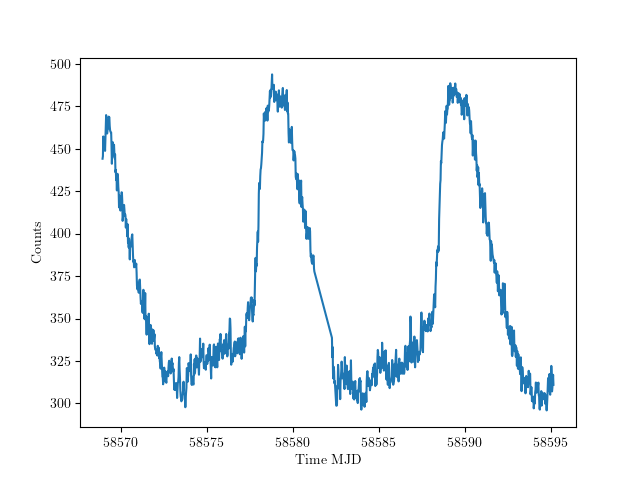

In [16]:
# what does the light curve look like?
tr.Plotter(lc[0],lc[1])

This light curve is pretty variable and few places with two isolated segments that might be called 'background' segments.

<IPython.core.display.Javascript object>


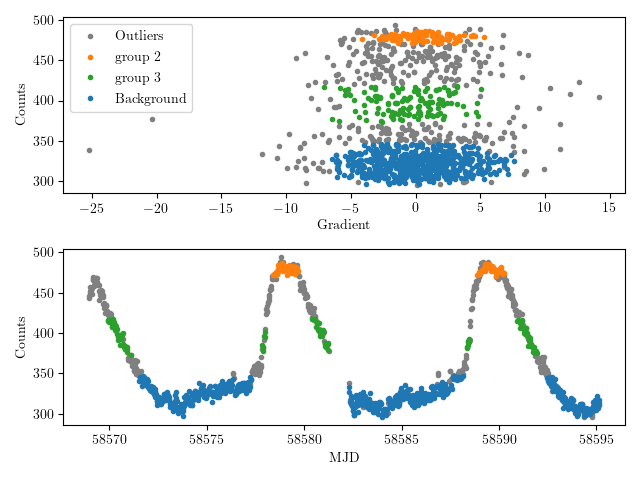

In [17]:
# clustering the light curve is as simple as the following lines 
arr = np.array([np.gradient(lc[1]),lc[1]])
clust = OPTICS(min_samples=6, xi=.05, min_cluster_size=.05)
opt = clust.fit(arr.T)
lab = opt.labels_
keys = np.unique(opt.labels_)

# lets see how well the clustering did 
colours = ['grey','C1','C2','C0','C3','C4']
labels = ['Outliers','group 2','group 3','Background','group 4']
plt.figure()
plt.subplot(211)
for i in range(len(keys)):
    plt.plot(np.gradient(lc[1])[lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i],label=labels[i])
plt.ylabel('Counts')
plt.xlabel('Gradient')
plt.legend()  

plt.subplot(212)
for i in range(len(keys)):
    plt.plot(lc[0,lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i])
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.tight_layout()

This case clearly isn't as good as SVS 1755, with some of the decline being included in the background group, and the clean structure in gradient-count space isn't clear anymore, but its still pretty good! 

What events do we pick out?

<IPython.core.display.Javascript object>


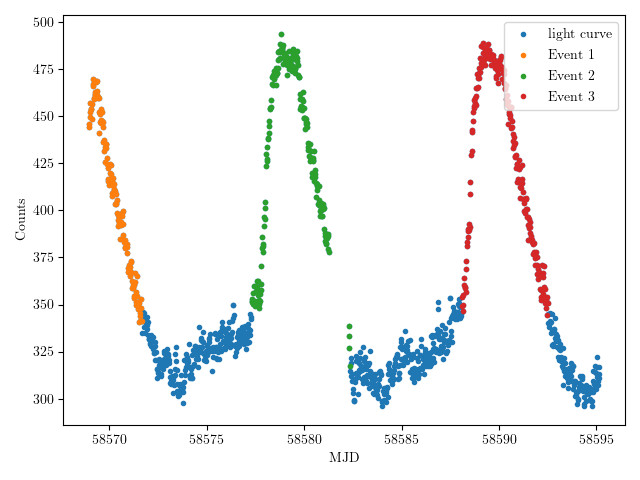

In [18]:
events = tr.Event_isolation(lc,)

# look at the events
plt.figure()
plt.plot(lc[0],lc[1],'.',label='light curve')
for i in range(len(events)):
    plt.plot(lc[0],events[i],'.',label='Event {}'.format(i+1))
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


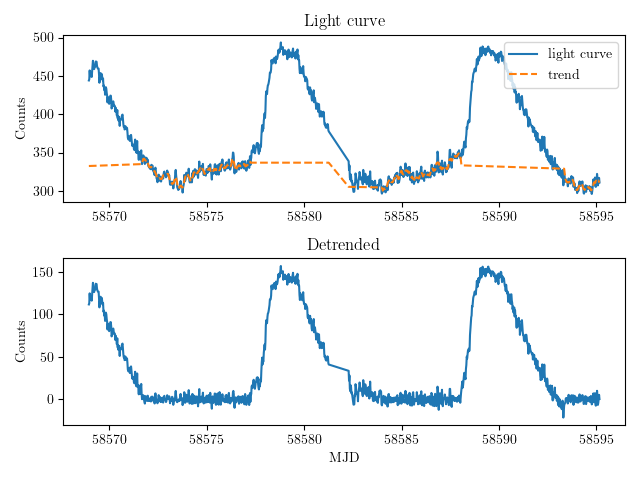

In [19]:
trend = tr.Remove_stellar_variability(lc)

plt.figure()
plt.subplot(211)
plt.title('Light curve')
plt.plot(lc[0],lc[1],label='light curve')
plt.plot(lc[0],trend,'--',label='trend')
plt.legend()
plt.ylabel('Counts')
plt.subplot(212)
plt.title('Detrended')
plt.plot(lc[0],lc[1]-trend)
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.tight_layout()

There is of course fine tuning that can be done for the clustering algorithm for individual cases, but as it currently stands, this method does an excellent job!

In [2]:
tpf = lk.search_targetpixelfile("TIC388857263", mission='TESS', sector=11).download()

In [3]:
res = tr.Quick_reduce(tpf,bin_size=0,aper=tpf.pipeline_mask,calibrate=False,shift=True,all_output=True)

Unlikely to get good shifts from a small tpf, so shift has been set to False
made reference
made source mask
calculating background
Small tpf, using percentile cut background
background subtracted
made light curve


<IPython.core.display.Javascript object>


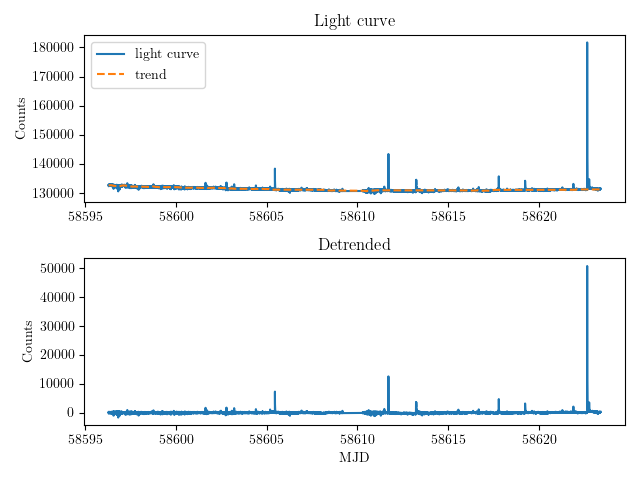

In [4]:
lc = res['lc']
trend = tr.Remove_stellar_variability(lc)

plt.figure()
plt.subplot(211)
plt.title('Light curve')
plt.plot(lc[0],lc[1],label='light curve')
plt.plot(lc[0],trend,'--',label='trend')
plt.legend()
plt.ylabel('Counts')
plt.subplot(212)
plt.title('Detrended')
plt.plot(lc[0],lc[1]-trend)
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.tight_layout()

<IPython.core.display.Javascript object>


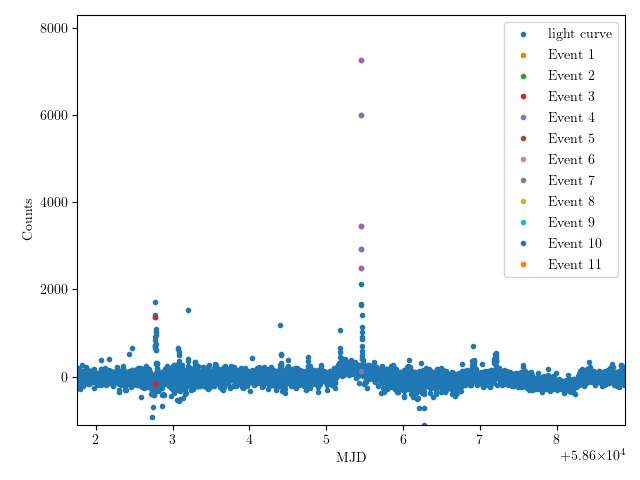

In [9]:
events = tr.Event_isolation(lc-trend,duration=1,sig=3)

# look at the events
plt.figure()
plt.plot(lc[0],lc[1]-trend,'.',label='light curve')
for i in range(len(events)):
    plt.plot(lc[0],events[i],'.',label='Event {}'.format(i+1))
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


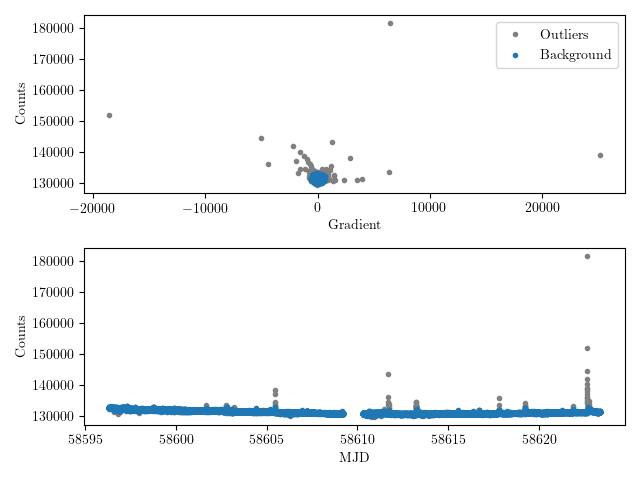

In [7]:
# clustering the light curve is as simple as the following lines 
arr = np.array([np.gradient(lc[1]-trend),lc[1]-trend])
clust = OPTICS(min_samples=4, xi=.05, min_cluster_size=.05)
opt = clust.fit(arr.T)
lab = opt.labels_
keys = np.unique(opt.labels_)

# lets see how well the clustering did 
colours = ['grey','C0']
labels = ['Outliers','Background']
plt.figure()
plt.subplot(211)
for i in range(len(keys)):
    plt.plot(np.gradient(lc[1])[lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i],label=labels[i])
plt.ylabel('Counts')
plt.xlabel('Gradient')
plt.legend()  

plt.subplot(212)
for i in range(len(keys)):
    plt.plot(lc[0,lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i])
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.tight_layout()